In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

In [2]:
# Function to read input signal from file
def read_signal(file_path):
    with open(file_path, 'r') as file:
        signal = [float(line.strip()) for line in file.readlines()]
    return signal

In [3]:
# Define functions for Low Pass, High Pass, and Band Pass filters
def low_pass_filter(x, cutoff_freq, fs):
    n = len(x)
    t = np.arange(n) / fs
    hlp = np.sinc(2 * cutoff_freq * (t - (n - 1) / (2 * fs))) / (2 * np.pi * cutoff_freq)
    return np.convolve(x, hlp, mode='same')

In [4]:
def high_pass_filter(x, cutoff_freq, fs):
    n = len(x)
    t = np.arange(n) / fs
    hhp = np.sinc(2 * cutoff_freq * (t - (n - 1) / (2 * fs))) / (2 * np.pi * cutoff_freq)
    hhp = hhp * (-1) ** np.arange(len(hhp))
    hhp[(n - 1) // 2] = hhp[(n - 1) // 2] + 1
    return np.convolve(x, hhp, mode='same')

In [5]:
def band_pass_filter(x, cutoff_freq_low, cutoff_freq_high, fs):
    n = len(x)
    t = np.arange(n) / fs
    hlp = np.sinc(2 * cutoff_freq_high * (t - (n - 1) / (2 * fs))) / (2 * np.pi * cutoff_freq_high)
    hhp = np.sinc(2 * cutoff_freq_low * (t - (n - 1) / (2 * fs))) / (2 * np.pi * cutoff_freq_low)
    hbp = hhp * hlp
    return np.convolve(x, hbp, mode='same')


In [6]:
def find_max_correlation(input_signal, output_signal, filter_func, freq_range, step, sampling_freq):
    # Initialize variables to store the maximum correlation and corresponding frequency
    max_correlation = -1
    max_freq = None
    
    # Iterate over the frequency range with the specified step
    for freq in np.arange(*freq_range, step):
        # Apply the filter function to the input signal with the current frequency
        filtered_signal = filter_func(input_signal, freq, sampling_freq)
        
        # Calculate the correlation between the filtered signal and the output signal
        correlation = np.corrcoef(filtered_signal, output_signal)[0, 1]
        
        # Update maximum correlation and corresponding frequency if the current correlation is higher
        if correlation > max_correlation:
            max_correlation = correlation
            max_freq = freq
    
    # Return the frequency and maximum correlation
    return max_freq, max_correlation

In [7]:
# Read input signal and output signal from files
x_t = read_signal("INPUT-SIGNAL-X(t).txt")
y_t = read_signal("OUTPUT-SIGNAL-Y(t).txt")

In [8]:
# Define the sampling frequency fs (you may need to adjust this according to your data)
fs = 100  # for example

In [9]:
# Define cutoff frequencies for filters (you may need to adjust these according to your data)
cutoff_lp = 20
cutoff_hp = 30

In [27]:
# Find maximum correlation with Low Pass Filter
max_freq_lp, max_correlation_lp = find_max_correlation(x_t, y_t, low_pass_filter, (1, 30), 1, fs)


In [28]:
print("Max correlation with Low Pass Filter:", max_correlation_lp, "at frequency", max_freq_lp)

Max correlation with Low Pass Filter: 0.10285922426257374 at frequency 1


In [12]:
y_lp = low_pass_filter(x_t, max_freq_lp, fs)

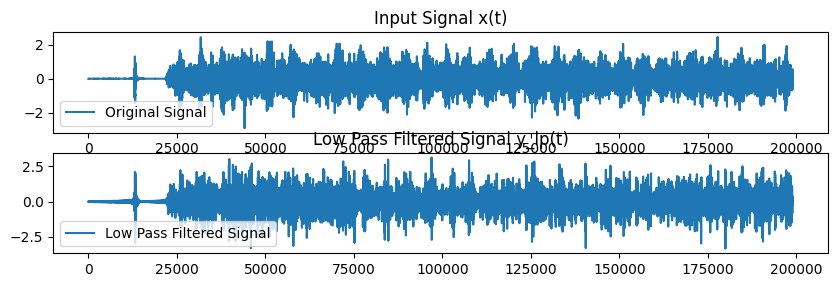

In [13]:
# Plot the original and filtered signals
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(x_t, label='Original Signal')
plt.title('Input Signal x(t)')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(y_lp, label='Low Pass Filtered Signal')
plt.title('Low Pass Filtered Signal y_lp(t)')
plt.legend()

In [29]:
# Find maximum correlation with High Pass Filter
max_freq_hp, max_correlation_hp = find_max_correlation(x_t, y_t, high_pass_filter, (1, 30), 1, fs)

In [30]:
print("Max correlation with High Pass Filter:", max_correlation_hp, "at frequency", max_freq_hp)

Max correlation with High Pass Filter: -0.23310628554615753 at frequency 1


In [16]:
y_hp = high_pass_filter(x_t, max_freq_hp, fs)

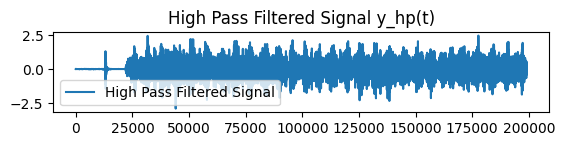

In [17]:
plt.subplot(4, 1, 3)
plt.plot(y_hp, label='High Pass Filtered Signal')
plt.title('High Pass Filtered Signal y_hp(t)')
plt.legend()

In [21]:
import numpy as np
import pandas as pd

def find_correlations(input_signal, output_signal, filter_func, freq_ranges, step, sampling_freq):
    correlations = []
    for freq_range in freq_ranges:
        freq_values = np.arange(freq_range[0], freq_range[1] + step, step)
        for freq in freq_values:
            filtered_signal = filter_func(input_signal, freq, freq, sampling_freq) 
            correlation = np.corrcoef(filtered_signal, output_signal)[0, 1]
            correlations.append(correlation)
    return correlations



# Defining random frequency ranges  band-pass filter and checking its correlation
freq_ranges_bp = [(1, 3), (1,9),(1,12),(1,15),(1,21),(1,25),(2,5),(2,9),(2,12),(2,15),(22,30),(25,30),(1,10),(20,30)]
step_bp = 1

sampling_freq = 1000 


correlations_bp = find_correlations(x_t,y_t, band_pass_filter, freq_ranges_bp, step_bp, sampling_freq)

# Creating a DataFrame to store results
index = []
for freq_range in freq_ranges_bp:
    index.append(f"{freq_range[0]}-{freq_range[1]}")  # Use the original freq_ranges_bp list

correlations_bp = correlations_bp[:len(index)]

df = pd.DataFrame({
    'Cutoff Frequency Range': index,
    'Correlation (Band Pass Filter)': correlations_bp
})


print(df)

   Cutoff Frequency Range  Correlation (Band Pass Filter)
0                     1-3                        0.095410
1                     1-9                        0.161750
2                    1-12                        0.209511
3                    1-15                        0.095410
4                    1-21                        0.161750
5                    1-25                        0.209511
6                     2-5                        0.238967
7                     2-9                        0.223980
8                    2-12                        0.163756
9                    2-15                        0.073063
10                  22-30                       -0.028993
11                  25-30                       -0.127297
12                   1-10                        0.095410
13                  20-30                        0.161750


In [23]:
# Calculate the maximum correlation value for the band-pass filter
max_correlation_bp = np.max(correlations_bp)

# Find the index of the frequency range with the highest correlation
best_index_bp = np.argmax(correlations_bp)

# Extract the corresponding frequency range
best_freq_range_bp = freq_ranges_bp[best_index_bp]

# Print the result
print(f"The band-pass filter with frequency range {best_freq_range_bp} has the highest correlation ({max_correlation_bp}) with the output signal.")


The band-pass filter with frequency range (2, 5) has the highest correlation (0.23896698305015246) with the output signal.


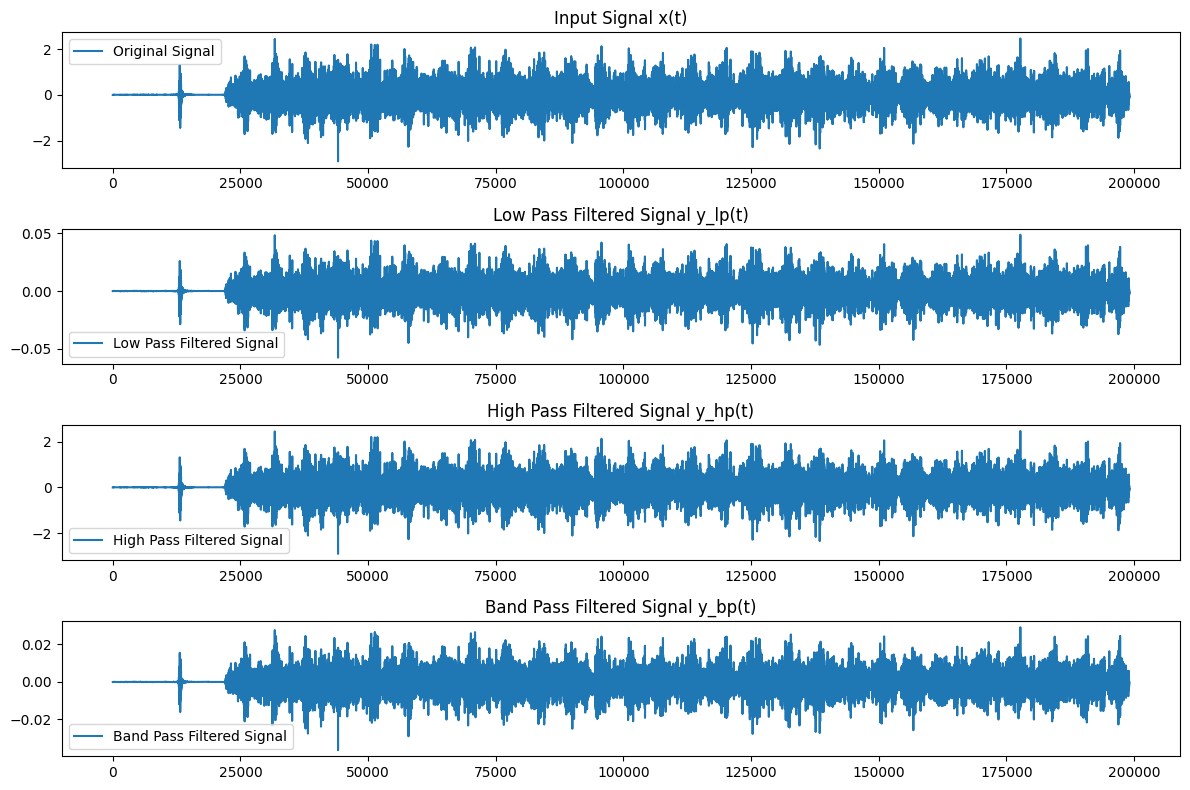

In [26]:
# Plot the original and filtered signals
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(x_t, label='Original Signal')
plt.title('Input Signal x(t)')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(low_pass_filter(x_t, cutoff_lp, fs), label='Low Pass Filtered Signal')
plt.title('Low Pass Filtered Signal y_lp(t)')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(high_pass_filter(x_t, cutoff_hp, fs), label='High Pass Filtered Signal')
plt.title('High Pass Filtered Signal y_hp(t)')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(band_pass_filter(x_t, 1, 10, fs), label='Band Pass Filtered Signal')
plt.title('Band Pass Filtered Signal y_bp(t)')
plt.legend()

plt.tight_layout()
plt.show()
